In [5]:
from peer_review_assignments import *
import numpy as np
from vancouver import *
import matplotlib.pyplot as plt
%matplotlib inline  


In [9]:

# generate groups

L = [chr(ord('a') + z) for z in range(26)];
bigL = [x + y for x in L for y in L]
bigGroups = {sub : [sub + x for x in ['1','2','3']] for sub in bigL[:90]};

# relevant info for these groups
submissions = bigGroups.keys()
exclude = invert_dictlist(bigGroups)
students = exclude.keys()


# initialize some variables
submissionVariances = [];
studentQualities = [];

number_of_trials = 1;
number_of_steps = 15;
k = 3;

for _ in range(number_of_trials):

    # generate assignments
    emptycover = {s: [] for s in students}
    assignments = peer_assignment_with_cover(bigGroups,k,emptycover)

    # ground truth
    trueGrades = {j:0.5 for j in submissions}
    trueQualities = {i: random.getrandbits(1)*4+1 for i in students}

    # generate some grades
    reviews = random_reviews(assignments,trueQualities)
    (grades,qualities) = vancouver(reviews,trueGrades,number_of_steps);
    #(grades,qualities) = simple_vancouver(reviews,trueGrades,number_of_steps);

    # (true, estimate) pairs
    submissionVariances += [(1.0/12,grades[sub][1]) for sub in submissions]
    studentQualities += [(trueQualities[i],qualities[i]) for i in students]
    

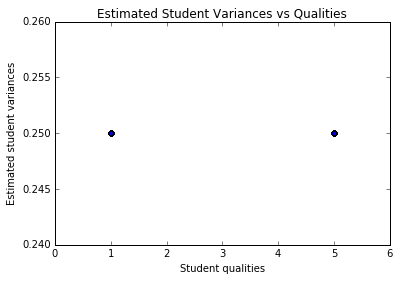

In [10]:
# plot student quality estimates
x = [v[0] for v in studentQualities]
y = [v[1] for v in studentQualities]
plt.scatter(x,y)
plt.xlabel('Student qualities')
plt.ylabel('Estimated student variances')
plt.title('Estimated Student Variances vs Qualities')
plt.show()

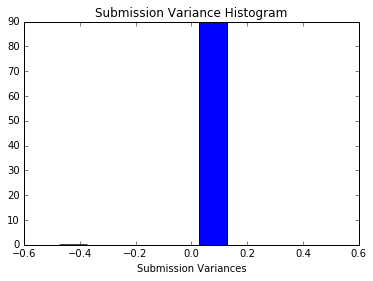

In [7]:
# plot submission variance histogram
# should be centered at 1/12
x = [v[1] for v in submissionVariances]
plt.hist(x)
plt.xlabel('Submission Variances')
plt.title('Submission Variance Histogram')
plt.show()